In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os 
import glob
from astropy.io import fits

Voici un ensemble de scripts simples qui vous permet de :

- **combiner des images,**
- **créer un 'master flat' et un 'master bias'**
- **traiter les données en utilisant ce master flat et master bias.**

> **Note :** Vous devez définir `data_dir` et `output_dir` pour le répertoire de votre groupe !


In [54]:
#ON IAP computers, set the path to this:
#data_dir = "/poubelles/broque1NS/tmp/hjmcc/tpnocturne-2019"

data_dir='/poubelles/broque1NS/tmp/hjmcc/tpnocturne-2024/Groupe5-M81/'
output_dir = '/poubelles/broque1NS/tmp/hjmcc/processed/'

In [11]:
image_file = os.path.join(data_dir,'CALIBRATIONS/Bias-0001.fits')

- `hdu_list = fits.open(image_file)`: Ouvre le fichier FITS spécifié (`image_file`) et charge son contenu dans une liste d'unités de données (Header Data Units, HDUs), permettant d'accéder aux données et aux en-têtes dans chaque extension du fichier.

- `hdu_list.info()`: Affiche un résumé des unités de données (HDUs) contenues dans le fichier FITS, incluant le type, la taille et le nom de chaque extension, ce qui est utile

- `image_data = hdu_list[0].data`: Accède aux données de l'image dans la première unité de données (HDU) du fichier FITS et les stocke dans la variable `image_data`. Cela permet de manipuler les données de l'image comme un tableau NumPy.

- `np.median(image_data[1000:2000, 100:2000])`: Calcule la médiane des valeurs de pixels dans la sous-région spécifiée de `image_data` (lignes 1000 à 2000 et colonnes 100 à 2000). Cette opération peut être utile pour estimer le bruit de fond ou la luminosité moyenne dans une zone spécifique de l'image.


In [13]:
hdu_list = fits.open(image_file)

In [7]:
hdu_list.info()

Filename: /Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/data-tpnocturne-2021/Bias/Bias_1_secs_2021-11-22T18-10-46_001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (3352, 2532)   int16 (rescales to uint16)   


In [15]:
image_data = hdu_list[0].data

In [16]:
np.median(image_data[1000:2000,100:2000])

np.float64(300.0)

In [30]:
np.std(image_data)

np.float64(6.959953887329656)

In [17]:
image_data = fits.getdata(image_file)
from matplotlib.colors import LogNorm

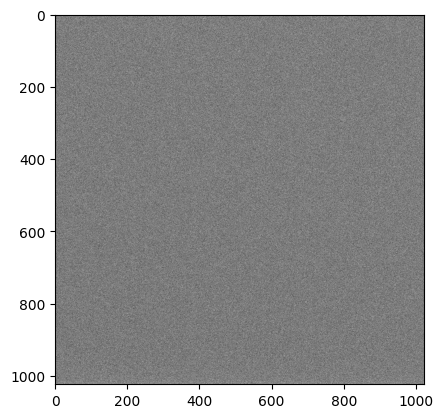

In [19]:
plt.imshow(image_data, cmap='gray')


In [20]:

image_list = glob.glob(os.path.join(data_dir, 'CALIBRATIONS/Bias*'))
np.size(image_list)

5

In [21]:
image_list[1]

'/poubelles/broque1NS/tmp/hjmcc/tpnocturne-2024/Groupe5-M81/CALIBRATIONS/Bias-0004.fits'

In [ ]:
# The long way
#image_concat = []
#for image in image_list:
#    image_concat.append(fits.getdata(image))

In [23]:
# The concise way
image_concat = [fits.getdata(image) for image in image_list]


In [48]:
final_bias = np.mean(image_concat, axis=0)

In [49]:
np.std(final_bias)

np.float64(3.12734000441267)

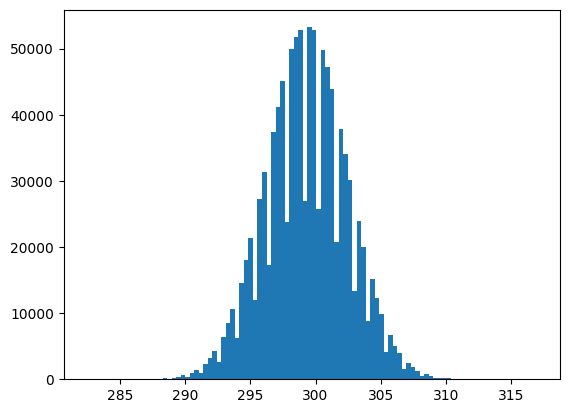

In [50]:
image_hist = plt.hist(final_bias.flatten(), bins=100)

In [51]:
np.std(image_data[1000:2000,100:2000])/np.sqrt(6.0)

np.float64(2.8631702371287497)

Note the noise in the master bias is *higher* than would expect from Poisson statistics. There
may be some other source of noise in the images (e.g., electrical noise) 

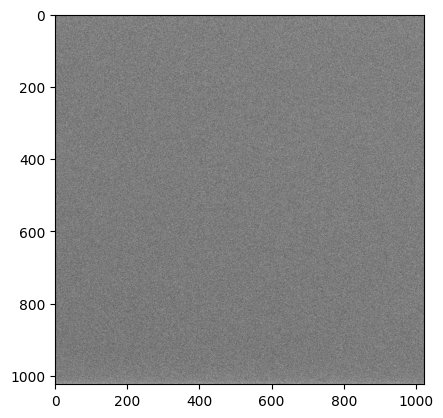

In [52]:
plt.imshow(final_bias, cmap='gray')


In [55]:
outfile = os.path.join(output_dir, 'median_bias.fits')
hdu = fits.PrimaryHDU(final_bias)
hdu.writeto(outfile, overwrite=True)

In [59]:
flat_list = glob.glob(data_dir+'/CALIBRATIONS/Flat-00*R*fits')
np.size(flat_list)

6

In [60]:
image_concat = []
for image in flat_list:
    image_concat.append(fits.getdata(image)-final_bias)
# subtract the bias at each step. 

In [61]:
# now get final flat 
flat = np.median(image_concat, axis=0)

In [62]:
final_flat = flat/np.mean(flat) 

In [63]:
final_flat

array([[0.88985387, 0.9161829 , 0.9246056 , ..., 0.81925337, 0.81420439,
        0.81368039],
       [0.94463631, 0.9246469 , 0.93468807, ..., 0.82624089, 0.82313045,
        0.81488069],
       [0.95321389, 0.92811356, 0.93907624, ..., 0.82973852, 0.82523935,
        0.82212375],
       ...,
       [0.96513423, 0.93029732, 0.95304095, ..., 0.96605575, 0.96197991,
        0.9590037 ],
       [0.96263039, 0.92648477, 0.94866052, ..., 0.96035887, 0.96459474,
        0.95906048],
       [0.89097931, 0.89959819, 0.92773153, ..., 0.94715306, 0.94069986,
        0.95008797]])

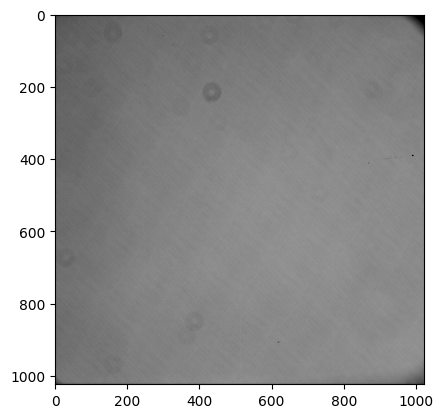

In [64]:
plt.imshow(final_flat, cmap='gray', vmin=0.9,vmax=1.1)


In [65]:
outfile = output_dir+'final_flatR.fits'
hdu = fits.PrimaryHDU(final_flat)
hdu.writeto(outfile, overwrite=True)

In [76]:
image_list = glob.glob(os.path.join(data_dir, 'M81/M81-00*r.fits'))
np.size(image_list)

30

Now process all images with this master flat and master bias. 

In [77]:
image_concat = []
for image in image_list:
#    print(fits.getdata(image).shape)
    processed = (fits.getdata(image)-final_bias)/final_flat
    image_concat.append(processed) 
    filename,file_extension=os.path.splitext(image)
    outfile=output_dir+os.path.basename(filename)+'_pr.fits'
    hdu = fits.PrimaryHDU(processed)
    hdu.writeto(outfile, overwrite=True)
    print(outfile)


/poubelles/broque1NS/tmp/hjmcc/processed/M81-0002r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0001r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0003r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0004r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0005r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0006r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0007r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0008r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0009r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0010r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0011r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0012r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0013r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0014r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0015r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0016r_pr.fits
/poubelles/broque1NS/tmp/hjmcc/processed/M81-0017r_pr.fi